In [142]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

In [2]:
vcf = "../../6_SNV_SV_Comparison/results/cutesv/vcfs/PacBio.full.vcf.gz"
fasta = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.fa"
rmsk = "/home/chenzonggui/species/homo_sapiens/RepeatMasker/hg38.fa.out.gz"

In [22]:
fw = open("sequences.fasta", "w+")
with pysam.VariantFile(vcf) as f:
    sample = list(f.header.samples)[0]
    for record in f:
        svtype = record.info["SVTYPE"]
        ref, alt = record.ref, record.alts[0]
        chrom = record.contig
        start = record.start
        stop = record.stop
        name = record.id
        if svtype == "INS":
            seq = alt[1:]
            start = record.start
            end = record.stop
        elif svtype == "DEL":
            seq = seq[1:]
            start = record.start
            end = record.stop
        else:
            continue
        fw.write(">%s %s:%d-%d\n" % (name, chrom, start, end))
        fw.write("%s\n" % seq)
fw.close()

In [ ]:
! RepeatMasker -pa 24 -species human -poly -html -gff -dir sequences_rmsk sequences.fasta > sequences_rmsk.log

In [104]:
data = defaultdict(list)
with open("sequences_rmsk/sequences.fasta.out") as f:
    for line in f.readlines()[3:]:
        # print(line.strip("\n"))
        row = line.split()
        # print(row)
        if row[8] == "+":
            begin, end, left = int(row[11]), int(row[12]), int(row[13][1:-1])
        elif row[8] == "C":
            left, end, begin = int(row[11][1:-1]), int(row[12]), int(row[13])
        element_length = end + left
        ratio = (end - begin) / element_length
        #if ratio < 0.9:
            #continue
        #if left > 10 or begin > 10:
        #    continue
        name = row[10]
        if name == "Unknown":
            continue
        if name.startswith("LINE") or name.startswith("SINE") or name.startswith("LTR") or name.startswith("Satellite"): #  or name.startswith("DNA"):
            data[row[4]].append(row[10])

In [105]:
def counting(elements):
    line = 0
    sine = 0
    ltr = 0
    tandem_repeat = 0
    for e in elements:
        if e.startswith("LINE"):
            line += 1
        if e.startswith("SINE"):
            sine += 1
        if e.startswith("LTR"):
            ltr += 1
        if e.startswith("Satellite"):
            tandem_repeat += 1
    return line, ltr, sine, tandem_repeat

counts = np.zeros(5)
counter = defaultdict(int)
for name, elements in data.items():
    if len(elements) == 0:
        continue
    line, ltr, sine, tandem_repeat = counting(elements)
    ss = []
    if line > 0:
        ss.append("%d LINE" % line)
    if ltr > 0:
        ss.append("%d LTR" % ltr)
    if sine > 0:
        ss.append("%d SINE" % sine)
    if tandem_repeat > 0:
        ss.append("%d Tandem repeat" % tandem_repeat)
    s = " + ".join(ss)
    if len(elements) > 1:
        counter[s] += 1
    if len(elements) == 1:
        if line == 1:
            counts[0] += 1
        elif ltr == 1:
            counts[1] += 1
        elif sine == 1:
            counts[2] += 1
        elif tandem_repeat == 1:
            counts[3] += 1
        else:
            pass
            # counts[5] += 1
    else:
        counts[4] += 1

In [106]:
counts / sum(counts)

array([0.09262283, 0.05892831, 0.40077186, 0.24536144, 0.20231557])

In [107]:
counts

array([ 624.,  397., 2700., 1653., 1363.])

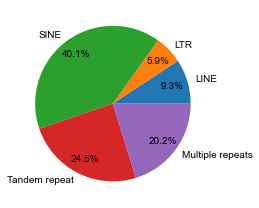

In [124]:
plt.figure(figsize=(4, 3))
plt.pie(counts, autopct="%.1f%%", pctdistance=0.8,
        labels=["LINE", "LTR", "SINE", "Tandem repeat", "Multiple repeats"])
plt.tight_layout()
plt.savefig("figures/repeat_distribution_pie.pdf", dpi=300)

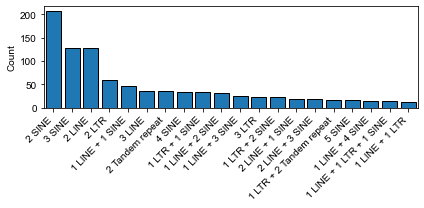

In [125]:
items = list(sorted(counter.items(), key=lambda item: item[1], reverse=True))
items = items[:20]

ys = [item[1] for item in items]
xs = np.arange(len(ys))
ticks = [item[0] for item in items]

plt.figure(figsize=(6, 3))
plt.bar(xs, ys, edgecolor="black", width=0.8)
plt.xticks(xs, ticks, rotation=45, ha="right")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/multiple_repeat_distribution_bar.pdf", dpi=300)

# Phased SVs

In [159]:
def load_sv_quantify(path):
    dat = pd.read_csv(path, sep="\t")
    dat.index = dat["Name"]
    min_cell = 1
    min_read = 2
    foldchange = 2
    ts = []
    d = dat[["AgreeRead", "AgreeCell", "DisagreeRead", "DisagreeCell"]]
    for agree_read, agree_cell, disagree_read, disagree_cell in d.values:
        t = "Uncertain" # Exist, NotExist
        if agree_cell >= min_cell and agree_cell >= disagree_cell * foldchange \
            and agree_read >= min_read and agree_read >= disagree_read * foldchange:
            t = "Exist"
        if disagree_cell >= min_cell and disagree_cell >= agree_cell * foldchange \
            and disagree_read >= min_read and disagree_read >= agree_read * foldchange:
            assert t != "Exist"
            t = "NotExist"
        ts.append(t)
    dat["Existence"] = ts
    return dat

path1 = "../../1_NanoStrandseq/results/assembly/HG001_Cell300/round2/quantify_psudobulk_sv.hp1_lite.tsv"
path2 = "../../1_NanoStrandseq/results/assembly/HG001_Cell300/round2/quantify_psudobulk_sv.hp2_lite.tsv"
        
dat1 = load_sv_quantify(path1)
dat2 = load_sv_quantify(path2)

In [160]:
dat2_tmp = dat2[dat2.columns[5:]]
dat = dat1.merge(dat2_tmp, left_index=True, right_index=True, suffixes=["_HP1", "_HP2"])

In [161]:
blacklist = [x for x in BedFile("../../1_NanoStrandseq/results/assembly/HG001_Cell300/blackhole/blacklist.bed.gz")]
print(len(blacklist))

regions = []
for chrom, start, end, name in dat[["Chrom", "Start", "End", "Name"]].values:
    obj = GRange(chrom=chrom, start=start, end=end, name=name)
    regions.append(obj)
regions.sort()

loader = ShiftLoader(blacklist)
retains = []
for r in regions:
    if len(list(loader.fetch(obj=r))) > 0:
        continue
    retains.append(r.name)
retains = set(retains)

1351


In [162]:
dat["Benchmark"] = [name in retains for name in dat["Name"]]

In [163]:
dat = dat[dat["Benchmark"]]

In [164]:
d1 = dat[(dat["Existence_HP1"] == "Exist") & (dat["Existence_HP2"] == "Exist")] # HOM
d2 = dat[(dat["Existence_HP1"] == "Exist") & (dat["Existence_HP2"] == "NotExist")] # HET on HP1
d3 = dat[(dat["Existence_HP1"] == "NotExist") & (dat["Existence_HP2"] == "Exist")] # HET on HP2
print(len(d1), len(d2), len(d3))

dat_phased = pd.concat([d1, d2, d3])
dat_phased

3321 3206 2920


,Chrom,Start,End,Name,Length,SupportRead_HP1,SupportCell_HP1,OverlapRead_HP1,OverlapCell_HP1,AgreeRead_HP1,...,SupportRead_HP2,SupportCell_HP2,OverlapRead_HP2,OverlapCell_HP2,AgreeRead_HP2,AgreeCell_HP2,DisagreeRead_HP2,DisagreeCell_HP2,Existence_HP2,Benchmark
Name,,,,,,,,,,,,,,,,,,,,,
cuteSV.DEL.65,chr1,934452,934804,cuteSV.DEL.65,351,2,1,21,7,11,...,2,1,10,7,5,4,1,1,Exist,True
cuteSV.INS.47,chr1,988826,988827,cuteSV.INS.47,50,1,1,15,4,11,...,1,1,11,4,9,4,2,2,Exist,True
cuteSV.DEL.227,chr1,1666973,1667141,cuteSV.DEL.227,167,48,9,16,9,14,...,48,6,11,5,11,5,0,0,Exist,True
cuteSV.INS.124,chr1,1924215,1924216,cuteSV.INS.124,98,41,7,13,6,12,...,41,4,9,3,9,3,0,0,Exist,True
cuteSV.INS.137,chr1,1993704,1993705,cuteSV.INS.137,143,63,8,17,8,16,...,63,11,38,10,38,10,0,0,Exist,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cuteSV.DEL.267736,chrX,148428176,148429714,cuteSV.DEL.267736,1537,18,1,32,12,0,...,18,4,9,5,3,2,0,0,Exist,True
cuteSV.DEL.267920,chrX,150759458,150760376,cuteSV.DEL.267920,917,21,1,49,16,0,...,21,4,18,7,6,3,1,1,Exist,True
cuteSV.DEL.267964,chrX,151125467,151127233,cuteSV.DEL.267964,1765,23,1,42,14,0,...,23,8,23,8,19,7,4,1,Exist,True


In [167]:
phased_svs = set(dat_phased["Name"])

In [168]:
fw = open("phased_sequences.fasta", "w+")
with pysam.VariantFile("../../1_NanoStrandseq/results/assembly/HG001_Cell300/sv/concat/cuteSV.vcf.gz") as f:
    sample = list(f.header.samples)[0]
    for record in f:
        svtype = record.info["SVTYPE"]
        ref, alt = record.ref, record.alts[0]
        chrom = record.contig
        start = record.start
        stop = record.stop
        name = record.id
        if svtype == "INS":
            seq = alt[1:]
            start = record.start
            end = record.stop
        elif svtype == "DEL":
            seq = seq[1:]
            start = record.start
            end = record.stop
        else:
            continue
        if name not in phased_svs:
            continue
        fw.write(">%s %s:%d-%d\n" % (name, chrom, start, end))
        fw.write("%s\n" % seq)
fw.close()

In [ ]:
! RepeatMasker -pa 24 -species human -poly -html -gff -dir phased_sequences_rmsk phased_sequences.fasta > phased_sequences_rmsk.log

In [169]:
data = defaultdict(list)
with open("phased_sequences_rmsk/phased_sequences.fasta.out") as f:
    for line in f.readlines()[3:]:
        row = line.split()
        if row[8] == "+":
            begin, end, left = int(row[11]), int(row[12]), int(row[13][1:-1])
        elif row[8] == "C":
            left, end, begin = int(row[11][1:-1]), int(row[12]), int(row[13])
        element_length = end + left
        ratio = (end - begin) / element_length
        name = row[10]
        if name == "Unknown":
            continue
        if name.startswith("LINE") or name.startswith("SINE") or name.startswith("LTR") or name.startswith("Satellite"): #  or name.startswith("DNA"):
            data[row[4]].append(row[10])

In [170]:
def counting(elements):
    line = 0
    sine = 0
    ltr = 0
    tandem_repeat = 0
    for e in elements:
        if e.startswith("LINE"):
            line += 1
        if e.startswith("SINE"):
            sine += 1
        if e.startswith("LTR"):
            ltr += 1
        if e.startswith("Satellite"):
            tandem_repeat += 1
    return line, ltr, sine, tandem_repeat

counts = np.zeros(5)
counter = defaultdict(int)
for name, elements in data.items():
    if len(elements) == 0:
        continue
    line, ltr, sine, tandem_repeat = counting(elements)
    ss = []
    if line > 0:
        ss.append("%d LINE" % line)
    if ltr > 0:
        ss.append("%d LTR" % ltr)
    if sine > 0:
        ss.append("%d SINE" % sine)
    if tandem_repeat > 0:
        ss.append("%d Tandem repeat" % tandem_repeat)
    s = " + ".join(ss)
    if len(elements) > 1:
        counter[s] += 1
    if len(elements) == 1:
        if line == 1:
            counts[0] += 1
        elif ltr == 1:
            counts[1] += 1
        elif sine == 1:
            counts[2] += 1
        elif tandem_repeat == 1:
            counts[3] += 1
        else:
            pass
            # counts[5] += 1
    else:
        counts[4] += 1

In [171]:
counts / sum(counts)

array([0.13284609, 0.07738607, 0.52493551, 0.0533104 , 0.21152193])

In [172]:
counts

array([ 309.,  180., 1221.,  124.,  492.])

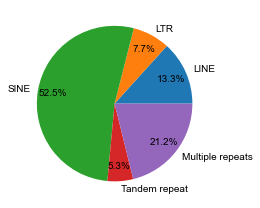

In [173]:
plt.figure(figsize=(4, 3))
plt.pie(counts, autopct="%.1f%%", pctdistance=0.8,
        labels=["LINE", "LTR", "SINE", "Tandem repeat", "Multiple repeats"])
plt.tight_layout()
plt.savefig("figures/phased_repeat_distribution_pie.pdf", dpi=300)

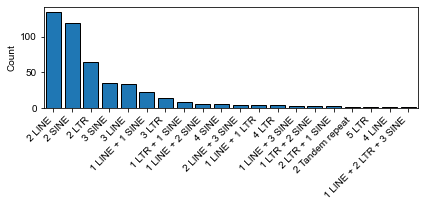

In [174]:
items = list(sorted(counter.items(), key=lambda item: item[1], reverse=True))
items = items[:20]

ys = [item[1] for item in items]
xs = np.arange(len(ys))
ticks = [item[0] for item in items]

plt.figure(figsize=(6, 3))
plt.bar(xs, ys, edgecolor="black", width=0.8)
plt.xticks(xs, ticks, rotation=45, ha="right")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/phased_multiple_repeat_distribution_bar.pdf", dpi=300)